In [10]:
import torch
import torch.nn as nn

class HelmholtzNN(nn.Module):
    def __init__(self, input_size=2, hidden_layer_size=50, output_size=1):
        super(HelmholtzNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.Tanh(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.Tanh(),
            nn.Linear(hidden_layer_size, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [11]:
def generate_data(domain_size, num_points):
    # Generate random points within the domain
    points = torch.rand((num_points, 2)) * 2 * domain_size - domain_size
    return points


In [12]:
def helmholtz_loss(model, points, k):
    points.requires_grad_(True)
    u_pred = model(points)
    u_pred_grad = torch.autograd.grad(u_pred.sum(), points, create_graph=True)[0]
    laplacian_u = torch.autograd.grad(u_pred_grad.sum(), points, create_graph=True)[0].sum(1, keepdim=True)
    equation_loss = torch.mean((laplacian_u + k**2 * u_pred) ** 2)
    # Assume some boundary_loss here, e.g., u_pred on boundary points should be 0
    # boundary_loss = ...
    total_loss = equation_loss # + boundary_loss
    return total_loss

In [13]:
def train(model, optimizer, epochs, k):
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        points = generate_data(domain_size=1.0, num_points=1000)
        loss = helmholtz_loss(model, points, k=k)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item()}')

# Initialize the model and optimizer
model = HelmholtzNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, optimizer, epochs=1000, k=5)


Epoch 0: Loss = 2.2999930381774902
Epoch 100: Loss = 0.00601021945476532
Epoch 200: Loss = 0.0006799589609727263
Epoch 300: Loss = 0.0002709986874833703
Epoch 400: Loss = 0.0001176212026621215
Epoch 500: Loss = 6.427748303394765e-05
Epoch 600: Loss = 5.420902743935585e-05
Epoch 700: Loss = 4.3313575588399544e-05
Epoch 800: Loss = 4.9341615522280335e-05
Epoch 900: Loss = 8.890788012649864e-05


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_solution(model, domain_size=1.0, resolution=100):
    # Generate a grid of points across the domain
    x = np.linspace(-domain_size, domain_size, resolution)
    y = np.linspace(-domain_size, domain_size, resolution)
    X, Y = np.meshgrid(x, y)
    grid = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
    
    # Predict the solution using the trained model
    with torch.no_grad():
        U_pred = model(grid).reshape(resolution, resolution).numpy()
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, U_pred, cmap='viridis', edgecolor='none')
    ax.set_title('Neural Network Solution of the 2D Helmholtz Equation')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


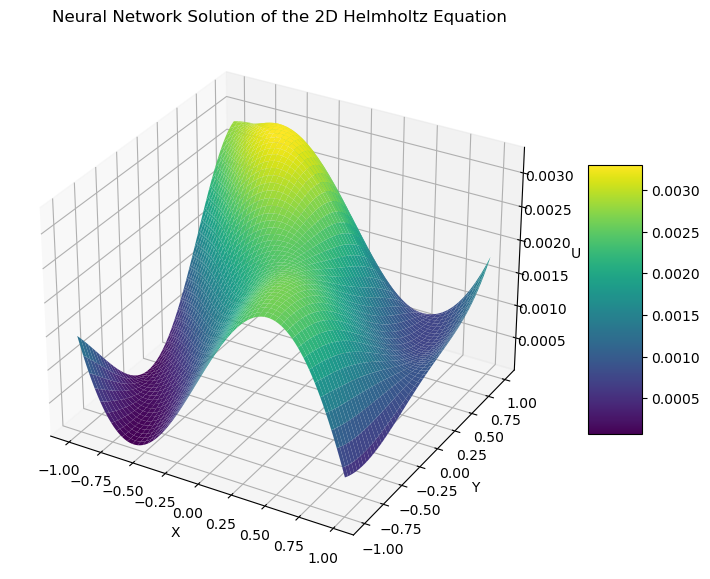

In [15]:
plot_solution(model)